# 1. Phase Stability Exploration for Water (1) + CPME (2) + Ethanol (3)

In this notebook, the region where the mixture of Water (1) + CPME (2) + Ethanol (3) splits into vapour-liquid-liquid equilibria (VLLE) is explored. The mixture is modelled using the SAFT-VR-Mie equation of state. All calculations are done using the [sgtpy](https://github.com/gustavochm/sgtpy) package.

This notebook is part of the Supplementary Information of the article *Description of isobaric vapor-liquid-liquid equilibrium for water + cyclopentyl methyl ether + alcohol (ethanol or propan-1-ol) ternary mixtures* by Andrés Mejía, Marcela Cartes, Gustavo Chaparro and Erich A. Müller.

First, the needed packages are imported.

In [1]:
import numpy as np
from sgtpy import component, mixture, saftvrmie
from sgtpy.equilibrium import tpd_minimas, vlle
import matplotlib.pyplot as plt
import pandas as pd

from plot_utils import plot_stability

np.seterr(all='ignore');

### Mixture definition

The mixture of Water (1) + CPME (2) + Ethanol (3) and its interaction parameters are defined using the `component` and `saftvrmie` functions.

The following mixing rules are applied for the molecular parameters:

$$ \sigma_{ij} = \frac{\sigma_i + \sigma_j}{2} ; \quad \epsilon_{ij} = (1-k_{ij}) \frac{\sqrt{\sigma_i^3 \sigma_j^3}}{\sigma_{ij}^3} \sqrt{\epsilon_i \epsilon_j} ;\quad \lambda_{k,ij} = \sqrt{(\lambda_{k,i} - 3)(\lambda_{k,j} - 3)} + 3 \quad k=a,r $$

Additionally, for cross-association: 

$$ r^{ABij}_c = \frac{r^{ABii}_c + r^{ABjj}_c}{2} ;\quad r^{ABij}_d = \frac{r^{ABii}_d + r^{ABjj}_d}{2} ;\quad \epsilon_{ij}^{AB} = (1 - l_{ij})\sqrt{\epsilon_{ii}^{AB} \epsilon_{jj}^{AB}} $$

Finally, if there is induced association (e.g., cpme-water, cpme-ethanol):

$$ \epsilon_{ij}^{AB} = \frac{\epsilon^{AB}  (self-associating)}{2} ;\quad  r^{ABij}_c (fitted)$$

In [2]:
water = component('water', ms = 1.7311, sigma = 2.4539 , eps = 110.85,
                  lambda_r = 8.308, lambda_a = 6.,  eAB = 1991.07, rcAB = 0.5624,
                  rdAB = 0.4, sites = [0,2,2])

cpme = component('cpme', ms =  2.32521144, sigma = 4.13606074, eps = 343.91193798, 
                 lambda_r = 14.15484877, lambda_a = 6.0, npol = 1.91990385, mupol = 1.27,
                 sites= [0,0,1])

ethanol = component('ethanol2C', ms = 1.7728, sigma = 3.5592 , eps = 224.50,
                    lambda_r = 11.319, lambda_a = 6., eAB = 3018.05, rcAB = 0.3547,
                    rdAB = 0.4, sites = [1,0,1])

# creating mixture
mix = water + cpme + ethanol

# water (1) - cpme (2)
k12 = -0.01606063
rc12 = 2.64635702
l12 = 0.

# water (1) - ethanol (3)
k13 = -0.00699825
l13 = -0.01518442

#cpme (2) - ethanol (3)
k23 =  0.01015004
rc23 = 2.23150428
l23 = 0.

# Setting up interactions between components
Kij = np.array([[0., k12, k13], [k12, 0., k23], [k13, k23, 0.]])
Lij = np.array([[0., l12, l13], [l12, 0., l23], [l13, l23, 0.]])

mix.kij_saft(Kij)
mix.lij_saft(Lij)
# Then eos object is created
eos = saftvrmie(mix)

# Induced association between Water-CPME
eos.eABij[0,1] = water.eAB / 2
eos.eABij[1,0] = water.eAB / 2
eos.rcij[0,1] = rc12 * 1e-10
eos.rcij[1,0] = rc12 * 1e-10

# Induced association between CPME-Ethanol
eos.eABij[1,2] = ethanol.eAB / 2
eos.eABij[2,1] = ethanol.eAB / 2
eos.rcij[1,2] = rc23 * 1e-10
eos.rcij[2,1] = rc23 * 1e-10

### Phase stability and equilibrium calculation

For simplicity, the phase stability of the mixture is explored at 349.5 K and 101325 Pa. The stability of the phases is tested using the tangent plane distance function. 

$$ tpd(\mathbf{w}) = \sum_{i=1}^c w_i \left[ \ln w_i + \ln \hat{\phi_i}(\mathbf{w}) - \ln z_i - \ln \hat{\phi_i}(\mathbf{z}) \right]$$

Here, $\mathbf{w}$ and $\mathbf{z}$ are the trial phase and global composition molar fraction vectors, respectively. $\hat{\phi_i}$ refers to the effective fugacity coefficient of component $i$. If there exists a trial phase ($\mathbf{w}$) for which the tpd function is negative, then the Gibbs free energy of the system would reduce if this phase were to be present in the system. Hence the original global mixture ($\mathbf{z}$) is unstable at this temperature and pressure conditions.

##### Case 1: Z = [0.5, 0.4, 0.1], T = 349.5K and P = 101325 Pa
For visualization, the `plot_stability` function point with a red square where the global trial composition lies. In the first example, `Z_trial = [0.5, 0.4, 0.1]` lies in the region where there are two liquid-like and one vapour-like trial phases with negative tpd values. In this plot, the background colour indicates the type of equilibria the system will likely split into, based only on the tpd test. **The dashed triangle indicates the region where the system splits into VLLE.**

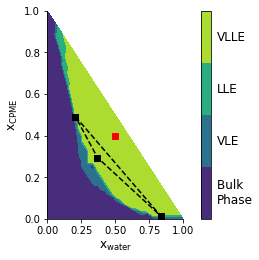

In [3]:
Z_trial = np.array([0.5, 0.4, 0.1])
plot_stability(Z_trial);

The stability test is done as follows:

1. A liquid-like global composition is tested against vapour-like trial phases. (To check for possible VLE)
2. A vapour-like global composition is tested against liquid-like trial phases. (to check for possible VLE)
3. A liquid-like global composition is tested against liquid-like trial phases. (To check for possible LLE)

The tpd minima are obtained using the `tpd_minimas` function from `sgtpy`. Possible duplicated minima are disregarded, and then the tpd values are sorted. 

In [4]:
T = 349.5  # K
P = 101325. # Pa
Z_trial = np.array([0.5, 0.4, 0.1])
Z = Z_trial

tpd_tol = -1e-3


########################################
# Test vapour trial phase against liquid
########################################
Y_trial, tpd_gas = tpd_minimas(3, Z, T, P, eos, stateW='V', stateZ='L')
Y_trial = np.array(Y_trial)

tpd_gas, index_unique = np.unique(tpd_gas, return_index=True)
sort = np.argsort(tpd_gas)
tpd_gas = tpd_gas[sort]
index_unique = index_unique[sort]
Y_trial = Y_trial[index_unique]
Y_trial = Y_trial[0]
tpd_gas = tpd_gas[0]

if tpd_gas < tpd_tol:
    # this means the liquid is unstable respect to the gas/vapour
    possible_vle_gas = True
else:
    possible_vle_gas = False


##############################################
# Test liquid trial phase against vapour phase
##############################################
X_vle_trial, tpd_vle_liq = tpd_minimas(5, Z, T, P, eos, stateW='L', stateZ='V')
X_vle_trial = np.array(X_vle_trial)
tpd_vle_liq, index_unique = np.unique(tpd_vle_liq, return_index=True)

sort = np.argsort(tpd_vle_liq)
tpd_vle_liq = tpd_vle_liq[sort]
index_unique = index_unique[sort]
X_vle_trial = X_vle_trial[index_unique]

tpd_vle_liq = tpd_vle_liq[0]
X_vle_trial = X_vle_trial[0]

if tpd_vle_liq < tpd_tol:
    # this means this gas/vapour is unstable respect to the liquid
    possible_vle_liq = True
else:
    possible_vle_liq = False
    

##############
# Test for LLE
##############
        
X_trials, tpd_liq = tpd_minimas(5, Z, T, P, eos, stateW='L', stateZ='L')
X_trials = np.array(X_trials)

tpd_liq, index_unique = np.unique(tpd_liq, return_index=True)
if len(index_unique) >= 2:
    sort = np.argsort(tpd_liq)
    tpd_liq = tpd_liq[sort]
    index_unique = index_unique[sort]
    X_trials = X_trials[index_unique]

    # getting the two lowest tpd values
    X_trials = X_trials[:2]
    tpd_liq = tpd_liq[:2]

    if np.any(tpd_liq < tpd_tol):
        possible_lle = True
    else:
        possible_lle = False
else: 
    possible_lle = False
    
probably_vle = possible_vle_liq and possible_vle_gas
probably_lle = possible_lle
probably_vlle = possible_vle_gas and possible_lle
probably_bulk_phase = (not probably_vle) and (not probably_lle) and (not probably_vlle)

print("Probably bulk phase: ", probably_bulk_phase)
print("Probably VLE: ", probably_vle)
print("Probably LLE: ", probably_lle)
print("Probably VLLE: ", probably_vlle)

Probably bulk phase:  False
Probably VLE:  True
Probably LLE:  True
Probably VLLE:  True


As shown above, this global composition has two liquid-like and one vapour-like trial phases with negative tpd values. Hence, the system is unstable and likely to split into VLLE. However, it is necessary to perform the actual phase equilibria calculation to check which phases are present. 

The calculation is done by solving the following modified [multiphase flash](https://www.sciencedirect.com/science/article/pii/037838129180021M):

$$ \sum_{i=1}^c \frac{z_i (K_{ik} \exp{\theta}-1)}{1+ \sum\limits^{\pi}_{\substack{j=1 \\ j \neq r}}{\beta_j (K_{ij}} \exp{\theta_j} -1)} = 0 \qquad k = 1,..., \pi,  k \neq r $$

Subject to:

$$ \beta_k \theta_k = 0 $$

In this system of equations, $z_i$ represents the global composition of the component $i$,  $ K_{ij} = x_{ij}/x_{ir} = \hat{\phi}_{ir}/\hat{\phi}_{ij} $ is the constant equilibrium of component $i$ in phase $j$ respect to the reference phase $r$, and $\beta_j$ and $\theta_j$ are the phase fraction and stability variable of the phase $j$. The stability variables $\theta_j$ are zero for stable phases and positive for unstable phases.

In [5]:
# Solving phase equilibria. 
# The minima found using tpd are used as initial guesses for the multipahse flash
X0 = X_trials[0]
W0 = X_trials[1]
Y0 = Y_trial

vlle(X0, W0, Y0, Z, T, P, eos, full_output=True, K_tol=1e-14, nacc=10)

           T: 349.5
           P: 101325.0
 error_outer: 5.895904912004722e-16
 error_inner: 2.678800510320148e-10
        iter: 16
        beta: array([0.47232228, 0.52767772, 0.        ])
       tetha: array([0.       , 0.       , 0.0633581])
           X: array([[0.93262597, 0.00473655, 0.06263747],
       [0.11275816, 0.75379879, 0.13344305],
       [0.41080067, 0.35907156, 0.23012777]])
           v: [2.123121765490564e-05, 0.00010327915746053408, 0.027770112805576567]
        Xass: [array([0.09690041, 0.12574569, 0.16893468, 0.02734804, 0.06122569]), array([0.1658988 , 0.69959581, 0.78772168, 0.09010266, 0.51976031]), array([0.98205527, 0.98826899, 0.99340252, 0.95250232, 0.97729829])]
      states: ['L', 'L', 'V']

As seen above, the multiphase flash detects this global composition at this temperature, and pressure converges to a liquid-liquid equilibrium (the vapour phase fraction is zero and its stability variable is positive). 

##### Case 2: Z = [0.5, 0.4, 0.1], T = 349.5K and P = 101325 Pa

In the second example, `Z_trial = [0.4, 0.3, 0.3]` lies in the region where there are two liquid-like and one vapour-like trial phases with negative tpd values. Additionally, this point is inside the region where the system splits into VLLE.

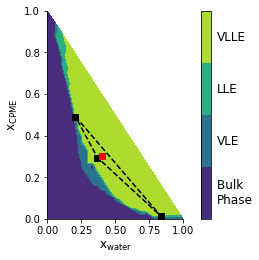

In [6]:
Z_trial = np.array([0.4, 0.3, 0.3])
plot_stability(Z_trial);

The stability test and phase equilibria calculations are repeated for this composition. 

In [7]:
T = 349.5  # K
P = 101325. # Pa
Z_trial = np.array([0.4, 0.3, 0.3])
Z = Z_trial

tpd_tol = -1e-3


########################################
# Test vapour trial phase against liquid
########################################
Y_trial, tpd_gas = tpd_minimas(3, Z, T, P, eos, stateW='V', stateZ='L')
Y_trial = np.array(Y_trial)

tpd_gas, index_unique = np.unique(tpd_gas, return_index=True)
sort = np.argsort(tpd_gas)
tpd_gas = tpd_gas[sort]
index_unique = index_unique[sort]
Y_trial = Y_trial[index_unique]
Y_trial = Y_trial[0]
tpd_gas = tpd_gas[0]

if tpd_gas < tpd_tol:
    # this means the liquid is unstable respect to the gas/vapour
    possible_vle_gas = True
else:
    possible_vle_gas = False


##############################################
# Test liquid trial phase against vapour phase
##############################################
X_vle_trial, tpd_vle_liq = tpd_minimas(5, Z, T, P, eos, stateW='L', stateZ='V')
X_vle_trial = np.array(X_vle_trial)
tpd_vle_liq, index_unique = np.unique(tpd_vle_liq, return_index=True)

sort = np.argsort(tpd_vle_liq)
tpd_vle_liq = tpd_vle_liq[sort]
index_unique = index_unique[sort]
X_vle_trial = X_vle_trial[index_unique]

tpd_vle_liq = tpd_vle_liq[0]
X_vle_trial = X_vle_trial[0]

if tpd_vle_liq < tpd_tol:
    # this means this gas/vapour is unstable respect to the liquid
    possible_vle_liq = True
else:
    possible_vle_liq = False
    

##############
# Test for LLE
##############
        
X_trials, tpd_liq = tpd_minimas(5, Z, T, P, eos, stateW='L', stateZ='L')
X_trials = np.array(X_trials)

tpd_liq, index_unique = np.unique(tpd_liq, return_index=True)
if len(index_unique) >= 2:
    sort = np.argsort(tpd_liq)
    tpd_liq = tpd_liq[sort]
    index_unique = index_unique[sort]
    X_trials = X_trials[index_unique]

    # getting the two lowest tpd values
    X_trials = X_trials[:2]
    tpd_liq = tpd_liq[:2]

    if np.any(tpd_liq < tpd_tol):
        possible_lle = True
    else:
        possible_lle = False
else: 
    possible_lle = False
    
probably_vle = possible_vle_liq and possible_vle_gas
probably_lle = possible_lle
probably_vlle = possible_vle_gas and possible_lle
probably_bulk_phase = (not probably_vle) and (not probably_lle) and (not probably_vlle)

print("Probably bulk phase: ", probably_bulk_phase)
print("Probably VLE: ", probably_vle)
print("Probably LLE: ", probably_lle)
print("Probably VLLE: ", probably_vlle)

# Solving phase equilibria. 
# The minima found using tpd are used as initial guesses for the multipahse flash

X0 = X_trials[0]
W0 = X_trials[1]
Y0 = Y_trial
vlle(X0, W0, Y0, Z, T, P, eos, full_output=True, K_tol=1e-14, nacc=15)

Probably bulk phase:  False
Probably VLE:  True
Probably LLE:  True
Probably VLLE:  True


           T: 349.5
           P: 101325.0
 error_outer: 8.407044606831486e-15
 error_inner: 1.849545761541976e-10
        iter: 46
        beta: array([0.15016751, 0.24403826, 0.60579423])
       tetha: array([0., 0., 0.])
           X: array([[0.83719426, 0.01205077, 0.15075497],
       [0.206991  , 0.49154168, 0.30146733],
       [0.36937774, 0.29421771, 0.33640456]])
           v: [2.5624338162480583e-05, 8.285814083765897e-05, 0.027659098803342084]
        Xass: [array([0.09676724, 0.16024466, 0.21479354, 0.0309602 , 0.07994998]), array([0.14343066, 0.52776315, 0.64133768, 0.07083661, 0.34144101]), array([0.97939729, 0.98714717, 0.99299832, 0.94900557, 0.97525219])]
      states: ['L', 'L', 'V']

In this case, the multiphase flash detects two liquids and one vapour that are stable (all the stability variables are zero). The system is in VLLE.